In [109]:
import ee
import pandas as pd
import plotly.graph_objs as go
from scipy.signal import savgol_filter

from src.controllers.plotter_processor import Plotter
from src.controllers.ndvi_processor import NDVIProcessor
from src.controllers.data_processor import DataProcessor
from src.controllers.ndvi_parameters import NDVIParameters
from src.controllers.ndvi_time_series import Sentinel, Landsat
from src.controllers.metrics_processor import PhenologicalMetrics

In [110]:
# Conecta ao Google Earth Engine
ee.Authenticate()
ee.Initialize()

In [122]:
# Datas de análise
start_date = '2022-12-01'
end_date = '2024-01-31'

# Selecionar os valores a cada 5 dias a partir de 05 de janeiro
start_date_base = f'{int(start_date[:4])+1}-01-05'
intervalo = 5

# Aplicar o filtro Savitzky-Golay
window_size = 30
poly_order = 4

#ID Poligono base Uilson
index_poligon = 583

#Order NDVI
order_ndvi = 30

In [123]:
import geopandas as gpd

# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(r'data\sample_full.gpkg')

gdf = gdf.explode(ignore_index=True)

gdf = gdf.to_crs("epsg:4326")

# Vamos supor que o seu GeoDataFrame tenha apenas um polígono, caso contrário, você pode iterar sobre cada polígono
polygon = gdf.geometry.iloc[index_poligon]

# Extrair os vértices do polígono
vertices = list(polygon.exterior.coords)

# Formatando os vértices no formato desejado
vertices_formatados = [[coord[0], coord[1]] for coord in vertices]

# Define the geometry
geometry = ee.Geometry.Polygon([
vertices_formatados
])

In [124]:
def add_ndvi(image):
    """
    Adds NDVI (Normalized Difference Vegetation Index) band to Landsat image.

    Args:
    - image (ee.Image): Landsat image.

    Returns:
    - ee.Image: Landsat image with NDVI band added.
    """
    nir = image.select('B5')
    red = image.select('B4')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    return image.addBands(ndvi)

In [125]:
def calculate_region_statistics( image):
    """
    Calculate region statistics for a given image.

    Args:
    - image (ee.Image): The input image.

    Returns:
    - ee.Feature: A feature containing region statistics as properties.
    """
    statistics = image.reduceRegion(reducer=ee.Reducer.median(),
                                    geometry=geometry,
                                    scale=10)
    feature = ee.Feature(None, statistics)
    return feature

In [126]:
def bitwise_extract_fmask(image):
    # Bits 3 and 5 are cloud shadow and cloud, respectively.
    clouds_bit_mask  = 1 << 1
    cloud_shadow_bit_mask = 1 << 3

    # Get the pixel QA band.
    qa = image.select('Fmask')

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
        .And(qa.bitwiseAnd(clouds_bit_mask).eq(0))

    # Return the masked image.
    return image.updateMask(mask)

def add_ndvi_fmask(image):

    nir = image.select('B5')
    red = image.select('B4')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    return ndvi.copyProperties(image, ['system:time_start'])

In [127]:
collection = ee.ImageCollection("NASA/HLS/HLSL30/v002")\
                    .filterBounds(geometry)\
                    .filter(ee.Filter.date('2023-01-01', '2023-12-30'))\
                    .map(bitwise_extract_fmask)\
                    .map(add_ndvi)\
                    .map(calculate_region_statistics)



In [128]:

ids = []
ndvi_values = []
dates = []

for image in collection.getInfo()['features']:
    ids.append(image['id'])
    ndvi_values.append(image['properties']['NDVI'])
    dates.append(image['id'].split('_')[1][:8])

data = {
    'date': dates,
    'id': ids,
    'ndvi': ndvi_values
}

df = pd.DataFrame(data)
df['satellite'] = 'landsat'
df = df.dropna()


In [129]:
ndvi_df = df.drop_duplicates('date').sort_values('date').reset_index(drop=True)

ndvi_df = df.drop_duplicates('date').sort_values('date').reset_index(drop=True)

# Convertendo a coluna 'date' para o formato datetime
ndvi_df['timestamps'] = pd.to_datetime(ndvi_df['date'])

# Definindo a coluna 'date' como o índice da tabela
ndvi_df.set_index('timestamps', inplace=True)

ndvi_df = ndvi_df.resample('D').interpolate(method='linear')

C:\Users\ander\AppData\Local\Temp\ipykernel_12900\2783770504.py:11: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [130]:
# Gerar dados de exemplo (pode substituir pelos seus próprios dados)
x = ndvi_df.index
y = ndvi_df['ndvi']

y_filtered = savgol_filter(y, window_size, poly_order)

# Criar a figura
fig = go.Figure()

# Adicionar os dados originais
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Dados Originais'))

# Adicionar os dados filtrados
fig.add_trace(go.Scatter(x=x, y=y_filtered, mode='lines', name='Dados Filtrados (Savitzky-Golay)'))

# Atualizar o layout
fig.update_layout(title=f'Filtro Savitzky-Golay - Poligono {1}',
                xaxis_title='X',
                yaxis_title='Y')


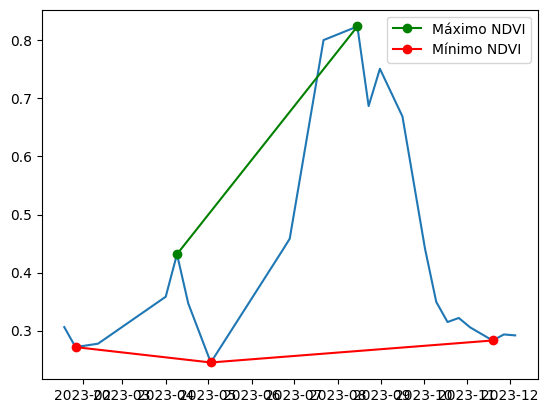

In [131]:
#!/usr/bin/python3
import matplotlib
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# Supondo que ndvi_df é seu DataFrame

# Generate random data.
data_x = ndvi_df.index
data_y = ndvi_df['ndvi']

# Find peaks (max).
peak_indexes = signal.argrelextrema(data_y.to_numpy(), np.greater, order=order_ndvi)[0]

# Find valleys (min).
valley_indexes = signal.argrelextrema(data_y.to_numpy(), np.less, order=order_ndvi)[0]

# Plot main graph.
fig, ax = plt.subplots()
ax.plot(data_x, data_y)

# Plot peaks.
peak_x = data_x[peak_indexes]
peak_y = data_y.iloc[peak_indexes]
ax.plot(peak_x, peak_y, marker='o',  color='green', label="Máximo NDVI")

# Plot valleys.
valley_x = data_x[valley_indexes]
valley_y = data_y.iloc[valley_indexes]
ax.plot(valley_x, valley_y, marker='o',  color='red', label="Mínimo NDVI")

# Show legend.
ax.legend()

# Show plot.
plt.show()